# **Object Detection with Faster RCNN**

In [65]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

We require the latest version of torchvision

In [66]:
!pip install -U torchvision # We need a new versi0o of torchvision for this project

Here are all the necessary libraries

In [67]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [69]:
print(torch.__version__)
print(torchvision.__version__)

2.1.2+cu121
0.16.2+cu121


PyCOCOTools provides many utilities for dealing with datasets in the COCO format, and if you wanted, you could evaluate the model's performance on the dataset with some of the utilities provided with this library.

That is out of scope for this notebook, however.

In [70]:
# our dataset is in cocoformat, we will need pypcoco tools
!pip install pycocotools
from pycocotools.coco import COCO

In [71]:
# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

We use albumentations as our data augmentation library due to its capability to deal with bounding boxes in multiple formats

In [72]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

## Dataset

This is our dataset class. It loads all the necessary files and it processes the data so that it can be fed into the model.

In [73]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [74]:
# Load the Drive helper and mount
# from google.colab import drive
# drive.mount('/content/gdrive')
dataset_path = "Hard-Hat-Sample-1"

In [75]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="6HVYt5AHIih5QnANq3bz")
project = rf.workspace("km-yrsfs").project("hard-hat-sample-arffm")
dataset = project.version(1).download("coco")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Hard-Hat-Sample-1 in coco:: 100%|██████████| 107/107 [00:00<00:00, 2749.59it/s]


In [76]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


{0: {'id': 0, 'name': 'Workers', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'head', 'supercategory': 'Workers'},
 2: {'id': 2, 'name': 'helmet', 'supercategory': 'Workers'},
 3: {'id': 3, 'name': 'person', 'supercategory': 'Workers'}}

This code just gets a list of classes

In [77]:
classes = [i[1]['name'] for i in categories.items()]
classes

['Workers', 'head', 'helmet', 'person']

In [78]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


This is a sample image and its bounding boxes, this code does not get the model's output

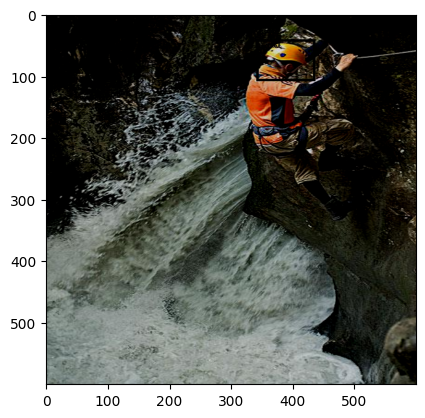

In [79]:
# Lets view a sample
sample = train_dataset[4]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [104]:
len(train_dataset)

70

## Model

Our model is FasterRCNN with a backbone of `MobileNetV3-Large`. We need to change the output layers because we have just 7 classes but this model was trained on 90 classes.

In [81]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

This is our collating function for the train dataloader, it allows us to create batches of data that can be easily pass into the model

In [82]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [83]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [84]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

The following blocks ensures that the model can take in the data and that it will not crash during training

In [85]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [86]:
device = torch.device("cuda") # use GPU to train

In [87]:
model = model.to(device)

## Optimizer

Here, we define the optimizer. If you wish, you can also define the LR Scheduler, but it is not necessary for this notebook since our dataset is so small.

> Note, there are a few bugs with the current way `lr_scheduler` is implemented. If you wish to use the scheduler, you will have to fix those bugs

In [88]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [89]:
import sys

## Training

The following is a function that will train the model for one epoch. Torchvision Object Detections models have a loss function built in, and it will calculate the loss automatically if you pass in the `inputs` and `targets`

In [90]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)

#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

#         if lr_scheduler is not None:
#             lr_scheduler.step() #

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

10 Epochs should be enough to train this model for a high accuracy

In [91]:
num_epochs = 50

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

100%|██████████| 18/18 [00:05<00:00,  3.49it/s]


Epoch 0, lr: 0.010000, loss: 0.784823, loss_classifier: 0.364983, loss_box: 0.325417, loss_rpn_box: 0.013373, loss_object: 0.081050


100%|██████████| 18/18 [00:06<00:00,  2.92it/s]


Epoch 1, lr: 0.010000, loss: 0.815839, loss_classifier: 0.332008, loss_box: 0.446996, loss_rpn_box: 0.010588, loss_object: 0.026246


100%|██████████| 18/18 [00:05<00:00,  3.25it/s]


Epoch 2, lr: 0.010000, loss: 0.647851, loss_classifier: 0.268615, loss_box: 0.343714, loss_rpn_box: 0.010114, loss_object: 0.025408


100%|██████████| 18/18 [00:08<00:00,  2.01it/s]


Epoch 3, lr: 0.010000, loss: 0.680378, loss_classifier: 0.270477, loss_box: 0.384021, loss_rpn_box: 0.008082, loss_object: 0.017799


100%|██████████| 18/18 [00:05<00:00,  3.05it/s]


Epoch 4, lr: 0.010000, loss: 0.611952, loss_classifier: 0.249989, loss_box: 0.340509, loss_rpn_box: 0.006935, loss_object: 0.014519


100%|██████████| 18/18 [00:06<00:00,  2.97it/s]


Epoch 5, lr: 0.010000, loss: 0.521170, loss_classifier: 0.202143, loss_box: 0.295433, loss_rpn_box: 0.007945, loss_object: 0.015650


100%|██████████| 18/18 [00:05<00:00,  3.59it/s]


Epoch 6, lr: 0.010000, loss: 0.641021, loss_classifier: 0.249723, loss_box: 0.373189, loss_rpn_box: 0.006405, loss_object: 0.011704


100%|██████████| 18/18 [00:03<00:00,  5.46it/s]


Epoch 7, lr: 0.010000, loss: 0.638517, loss_classifier: 0.245026, loss_box: 0.378697, loss_rpn_box: 0.006228, loss_object: 0.008567


100%|██████████| 18/18 [00:03<00:00,  5.35it/s]


Epoch 8, lr: 0.010000, loss: 0.655369, loss_classifier: 0.240089, loss_box: 0.400080, loss_rpn_box: 0.005985, loss_object: 0.009215


100%|██████████| 18/18 [00:04<00:00,  4.18it/s]


Epoch 9, lr: 0.010000, loss: 0.564078, loss_classifier: 0.191412, loss_box: 0.360612, loss_rpn_box: 0.005266, loss_object: 0.006788


100%|██████████| 18/18 [00:03<00:00,  5.47it/s]


Epoch 10, lr: 0.010000, loss: 0.624896, loss_classifier: 0.207987, loss_box: 0.403930, loss_rpn_box: 0.004955, loss_object: 0.008024


100%|██████████| 18/18 [00:03<00:00,  5.66it/s]


Epoch 11, lr: 0.010000, loss: 0.646478, loss_classifier: 0.227600, loss_box: 0.406644, loss_rpn_box: 0.005493, loss_object: 0.006742


100%|██████████| 18/18 [00:03<00:00,  5.20it/s]


Epoch 12, lr: 0.010000, loss: 0.610575, loss_classifier: 0.203240, loss_box: 0.394861, loss_rpn_box: 0.005052, loss_object: 0.007422


100%|██████████| 18/18 [00:03<00:00,  4.59it/s]


Epoch 13, lr: 0.010000, loss: 0.586264, loss_classifier: 0.183816, loss_box: 0.391553, loss_rpn_box: 0.005193, loss_object: 0.005702


100%|██████████| 18/18 [00:03<00:00,  5.58it/s]


Epoch 14, lr: 0.010000, loss: 0.585102, loss_classifier: 0.185856, loss_box: 0.388486, loss_rpn_box: 0.004720, loss_object: 0.006039


100%|██████████| 18/18 [00:03<00:00,  5.64it/s]


Epoch 15, lr: 0.010000, loss: 0.538266, loss_classifier: 0.165458, loss_box: 0.363637, loss_rpn_box: 0.005101, loss_object: 0.004070


100%|██████████| 18/18 [00:03<00:00,  5.38it/s]


Epoch 16, lr: 0.010000, loss: 0.558386, loss_classifier: 0.176369, loss_box: 0.371968, loss_rpn_box: 0.005707, loss_object: 0.004342


100%|██████████| 18/18 [00:03<00:00,  4.74it/s]


Epoch 17, lr: 0.010000, loss: 0.561862, loss_classifier: 0.167213, loss_box: 0.387018, loss_rpn_box: 0.003611, loss_object: 0.004020


100%|██████████| 18/18 [00:03<00:00,  5.56it/s]


Epoch 18, lr: 0.010000, loss: 0.551260, loss_classifier: 0.175630, loss_box: 0.364381, loss_rpn_box: 0.004325, loss_object: 0.006925


100%|██████████| 18/18 [00:03<00:00,  5.58it/s]


Epoch 19, lr: 0.010000, loss: 0.541162, loss_classifier: 0.170623, loss_box: 0.360651, loss_rpn_box: 0.004072, loss_object: 0.005816


100%|██████████| 18/18 [00:03<00:00,  5.24it/s]


Epoch 20, lr: 0.010000, loss: 0.591437, loss_classifier: 0.169661, loss_box: 0.413625, loss_rpn_box: 0.003668, loss_object: 0.004482


100%|██████████| 18/18 [00:03<00:00,  4.78it/s]


Epoch 21, lr: 0.010000, loss: 0.604789, loss_classifier: 0.176490, loss_box: 0.419509, loss_rpn_box: 0.004113, loss_object: 0.004677


100%|██████████| 18/18 [00:03<00:00,  5.63it/s]


Epoch 22, lr: 0.010000, loss: 0.518079, loss_classifier: 0.176991, loss_box: 0.333680, loss_rpn_box: 0.003432, loss_object: 0.003976


100%|██████████| 18/18 [00:03<00:00,  5.34it/s]


Epoch 23, lr: 0.010000, loss: 0.575906, loss_classifier: 0.173809, loss_box: 0.392822, loss_rpn_box: 0.003836, loss_object: 0.005439


100%|██████████| 18/18 [00:03<00:00,  5.21it/s]


Epoch 24, lr: 0.010000, loss: 0.642484, loss_classifier: 0.204114, loss_box: 0.426574, loss_rpn_box: 0.003889, loss_object: 0.007907


100%|██████████| 18/18 [00:03<00:00,  4.78it/s]


Epoch 25, lr: 0.010000, loss: 0.484415, loss_classifier: 0.174474, loss_box: 0.297422, loss_rpn_box: 0.003807, loss_object: 0.008712


100%|██████████| 18/18 [00:03<00:00,  4.82it/s]


Epoch 26, lr: 0.010000, loss: 0.506091, loss_classifier: 0.183296, loss_box: 0.312669, loss_rpn_box: 0.003980, loss_object: 0.006145


100%|██████████| 18/18 [00:03<00:00,  5.61it/s]


Epoch 27, lr: 0.010000, loss: 0.509440, loss_classifier: 0.158934, loss_box: 0.341187, loss_rpn_box: 0.003731, loss_object: 0.005588


100%|██████████| 18/18 [00:03<00:00,  4.82it/s]


Epoch 28, lr: 0.010000, loss: 0.607230, loss_classifier: 0.178357, loss_box: 0.419958, loss_rpn_box: 0.003596, loss_object: 0.005320


100%|██████████| 18/18 [00:03<00:00,  5.36it/s]


Epoch 29, lr: 0.010000, loss: 0.487015, loss_classifier: 0.151982, loss_box: 0.327372, loss_rpn_box: 0.003391, loss_object: 0.004270


100%|██████████| 18/18 [00:03<00:00,  5.62it/s]


Epoch 30, lr: 0.010000, loss: 0.511027, loss_classifier: 0.150341, loss_box: 0.353147, loss_rpn_box: 0.003280, loss_object: 0.004259


100%|██████████| 18/18 [00:03<00:00,  5.73it/s]


Epoch 31, lr: 0.010000, loss: 0.488728, loss_classifier: 0.154869, loss_box: 0.326013, loss_rpn_box: 0.003242, loss_object: 0.004604


100%|██████████| 18/18 [00:05<00:00,  3.08it/s]


Epoch 32, lr: 0.010000, loss: 0.561676, loss_classifier: 0.154440, loss_box: 0.401339, loss_rpn_box: 0.002875, loss_object: 0.003023


100%|██████████| 18/18 [00:04<00:00,  4.38it/s]


Epoch 33, lr: 0.010000, loss: 0.531432, loss_classifier: 0.166659, loss_box: 0.358384, loss_rpn_box: 0.003131, loss_object: 0.003258


100%|██████████| 18/18 [00:03<00:00,  5.53it/s]


Epoch 34, lr: 0.010000, loss: 0.550714, loss_classifier: 0.159619, loss_box: 0.384589, loss_rpn_box: 0.002844, loss_object: 0.003662


100%|██████████| 18/18 [00:03<00:00,  5.25it/s]


Epoch 35, lr: 0.010000, loss: 0.488399, loss_classifier: 0.136605, loss_box: 0.345037, loss_rpn_box: 0.002959, loss_object: 0.003798


100%|██████████| 18/18 [00:03<00:00,  4.86it/s]


Epoch 36, lr: 0.010000, loss: 0.575961, loss_classifier: 0.173462, loss_box: 0.395755, loss_rpn_box: 0.003374, loss_object: 0.003370


100%|██████████| 18/18 [00:03<00:00,  5.84it/s]


Epoch 37, lr: 0.010000, loss: 0.504294, loss_classifier: 0.140071, loss_box: 0.357447, loss_rpn_box: 0.003107, loss_object: 0.003669


100%|██████████| 18/18 [00:03<00:00,  5.80it/s]


Epoch 38, lr: 0.010000, loss: 0.594762, loss_classifier: 0.188568, loss_box: 0.398738, loss_rpn_box: 0.003453, loss_object: 0.004002


100%|██████████| 18/18 [00:03<00:00,  5.41it/s]


Epoch 39, lr: 0.010000, loss: 0.549422, loss_classifier: 0.166877, loss_box: 0.375022, loss_rpn_box: 0.003017, loss_object: 0.004507


100%|██████████| 18/18 [00:03<00:00,  4.85it/s]


Epoch 40, lr: 0.010000, loss: 0.435020, loss_classifier: 0.127376, loss_box: 0.299725, loss_rpn_box: 0.003453, loss_object: 0.004466


100%|██████████| 18/18 [00:03<00:00,  5.63it/s]


Epoch 41, lr: 0.010000, loss: 0.462493, loss_classifier: 0.130103, loss_box: 0.326122, loss_rpn_box: 0.003064, loss_object: 0.003204


100%|██████████| 18/18 [00:03<00:00,  5.63it/s]


Epoch 42, lr: 0.010000, loss: 0.452891, loss_classifier: 0.119986, loss_box: 0.325966, loss_rpn_box: 0.003026, loss_object: 0.003912


100%|██████████| 18/18 [00:03<00:00,  5.14it/s]


Epoch 43, lr: 0.010000, loss: 0.491925, loss_classifier: 0.131416, loss_box: 0.353913, loss_rpn_box: 0.003099, loss_object: 0.003497


100%|██████████| 18/18 [00:03<00:00,  4.90it/s]


Epoch 44, lr: 0.010000, loss: 0.477787, loss_classifier: 0.129521, loss_box: 0.341679, loss_rpn_box: 0.002915, loss_object: 0.003672


100%|██████████| 18/18 [00:03<00:00,  5.72it/s]


Epoch 45, lr: 0.010000, loss: 0.499873, loss_classifier: 0.141133, loss_box: 0.352125, loss_rpn_box: 0.002805, loss_object: 0.003810


100%|██████████| 18/18 [00:03<00:00,  5.74it/s]


Epoch 46, lr: 0.010000, loss: 0.506423, loss_classifier: 0.137185, loss_box: 0.363012, loss_rpn_box: 0.002829, loss_object: 0.003396


100%|██████████| 18/18 [00:04<00:00,  4.11it/s]


Epoch 47, lr: 0.010000, loss: 0.475463, loss_classifier: 0.128683, loss_box: 0.340757, loss_rpn_box: 0.002655, loss_object: 0.003368


100%|██████████| 18/18 [00:04<00:00,  4.28it/s]


Epoch 48, lr: 0.010000, loss: 0.504350, loss_classifier: 0.126116, loss_box: 0.372807, loss_rpn_box: 0.002413, loss_object: 0.003014


100%|██████████| 18/18 [00:03<00:00,  5.73it/s]

Epoch 49, lr: 0.010000, loss: 0.546320, loss_classifier: 0.162263, loss_box: 0.376987, loss_rpn_box: 0.003134, loss_object: 0.003937


In [92]:
# our learning rate was too low, due to a lr scheduler bug. For this task, we wont need a scheudul.er

## Trying on sample Images

This is the inference code for the model. First, we set the model to evaluation mode and clear the GPU Cache. We also load a test dataset, so that we can use fresh images that the model hasn't seen.

In [93]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [94]:
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [95]:
img, _ = test_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

In [96]:
# it did learn

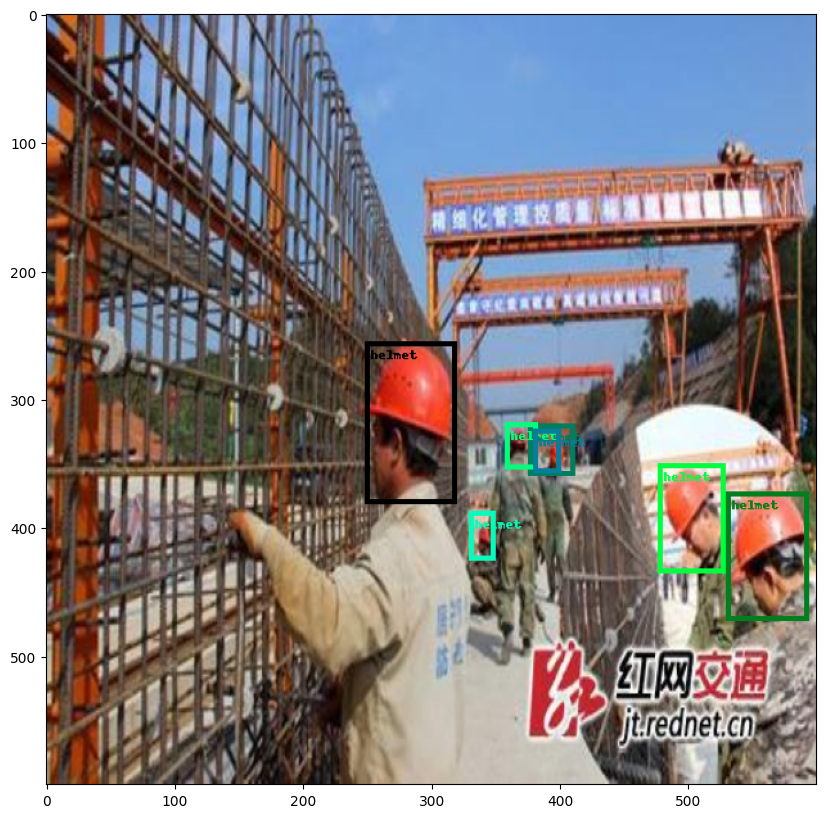

In [97]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.2],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.2].tolist()], width=4
).permute(1, 2, 0))

# Test data Ambil sendiri

In [102]:
import cv2
import torch

# Load and preprocess the image using OpenCV
img2 = cv2.imread("/content/cons2.jpg")
img_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Convert the image to a PyTorch tensor
img_tensor = torch.from_numpy(img_rgb).float()  # Convert to float tensor
img_tensor = img_tensor.permute(2, 0, 1)  # Adjust dimensions (if needed)
img_tensor = img_tensor.unsqueeze(0)  # Add a batch dimension

# Normalize values to [0, 1]
img_tensor = img_tensor / 255.0

# Move the tensor to the desired device (if using GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_tensor = img_tensor.to(device)

# Now you can use 'img_tensor' in your model
with torch.no_grad():
    prediction = model(img_tensor)
    pred = prediction[0]


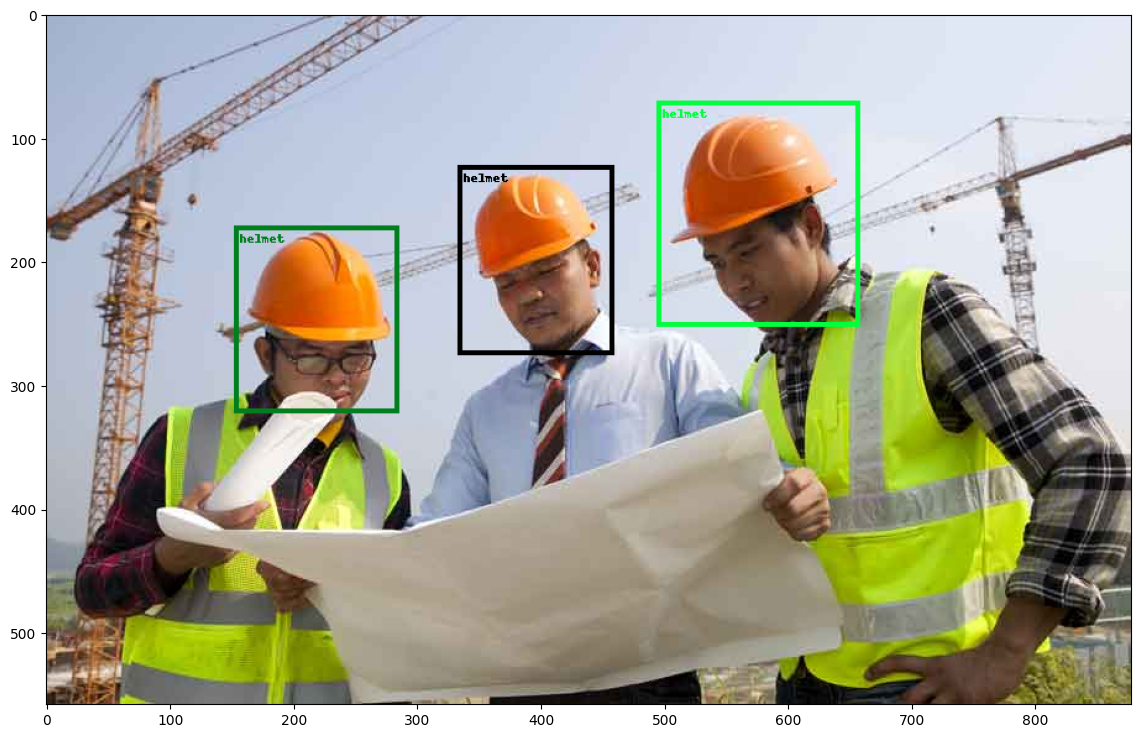

In [103]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'img_uint8' is your NumPy array and 'pred' contains predictions

# Convert NumPy array to PyTorch tensor
img_tensor = torch.from_numpy(img_rgb)
img_tensor = img_tensor.permute(2, 0, 1)  # Change dimensions if needed

# Ensure the image tensor is in the RGB format
if img_tensor.size(0) == 1:  # If the image is grayscale, convert it to RGB
    img_tensor = img_tensor.repeat(3, 1, 1)

# Visualize bounding boxes on the image
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_tensor,
    pred['boxes'][pred['scores'] > 0.2],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.2].tolist()], width=4
).permute(1, 2, 0))

plt.show()
